# Drake Passage Transport

This notebook calculates and plots a timeseries of Drake Passage transport and the barotropic stremfunction over the final year of each experiment.

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm

In [2]:
db='/g/data/ik11/outputs/mom6-panan/panant.db'
session=cc.database.create_session(db)
expts = ['panant-v2','panant-hycom1','panant-01-zstar','panant-01-hycom1']

## Drake Passage Timeseries

Uses barotropic flow through 71°W.

152.45183
143.33188
150.87242
146.54608


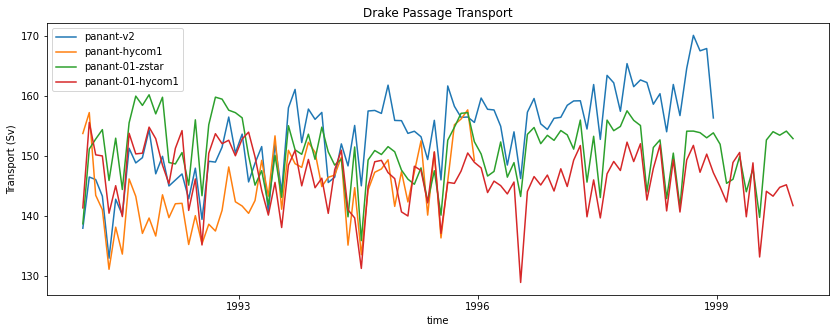

In [3]:
plt.figure(figsize=(14,5))

for expt in expts:
    umo_2d = cc.querying.getvar(expt,'umo_2d', session)
    DP = umo_2d.sel(xq=-71,method='nearest').sum('yh')/1e9
    DP.plot(label=expt)
    print(DP.isel(time=slice(-12,)).mean('time').values)
    
plt.title('Drake Passage Transport')
plt.ylabel('Transport (Sv)')
plt.legend()

# Barotropic streamfunction maps

These are currently calculated over the final year of each experiment.

In [4]:
depth = cc.querying.getvar('panant-01-zstar','deptho',session,n=1)
land_mask = np.squeeze(depth.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

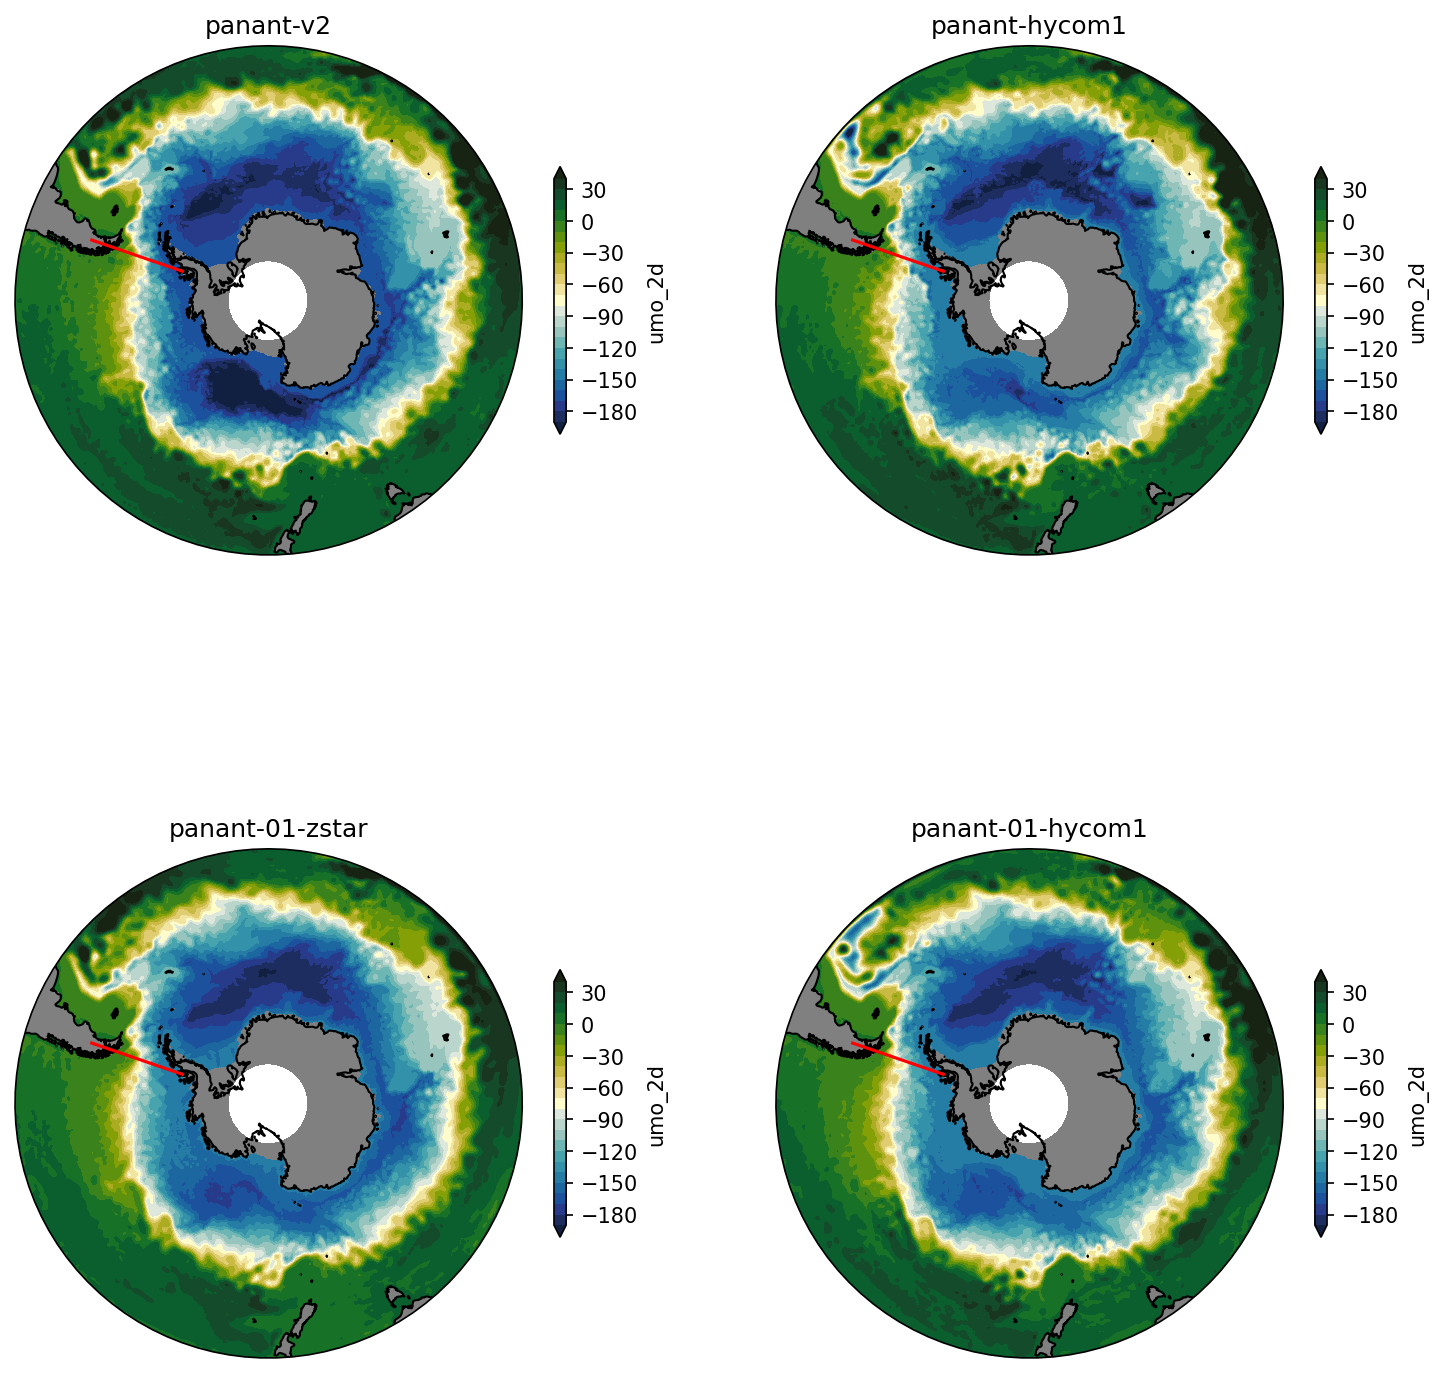

In [5]:
projection=ccrs.SouthPolarStereo()
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig = plt.figure(figsize=(12, 13), dpi=150)
ii=0
for expt in expts:
    ii+=1
    umo_2d = cc.querying.getvar(expt,'umo_2d', session)
    psi = umo_2d.isel(time=slice(-12,-1)).mean('time').cumsum('yh')/1e9
    psi = (psi - psi.sel(xq=-71,method='nearest').sel(yh=-40,method='nearest')).load()


    ax = plt.subplot(2, 2, ii, projection=projection)
    psi.plot.contourf(ax=ax,levels=np.arange(-190,50,10),transform=ccrs.PlateCarree(),
                      cmap=cm.cm.delta,cbar_kwargs={'shrink': 0.4})
    ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')

    ax.coastlines(resolution='50m')
    ax.plot([-71,-71],[-70,-50],color='r',transform=ccrs.PlateCarree())
    ax.set_extent([-280, 80, -82, -37], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    plt.title(expt)

In [6]:
speed = cc.querying.getvar('panant-01-zstar','speed', session)

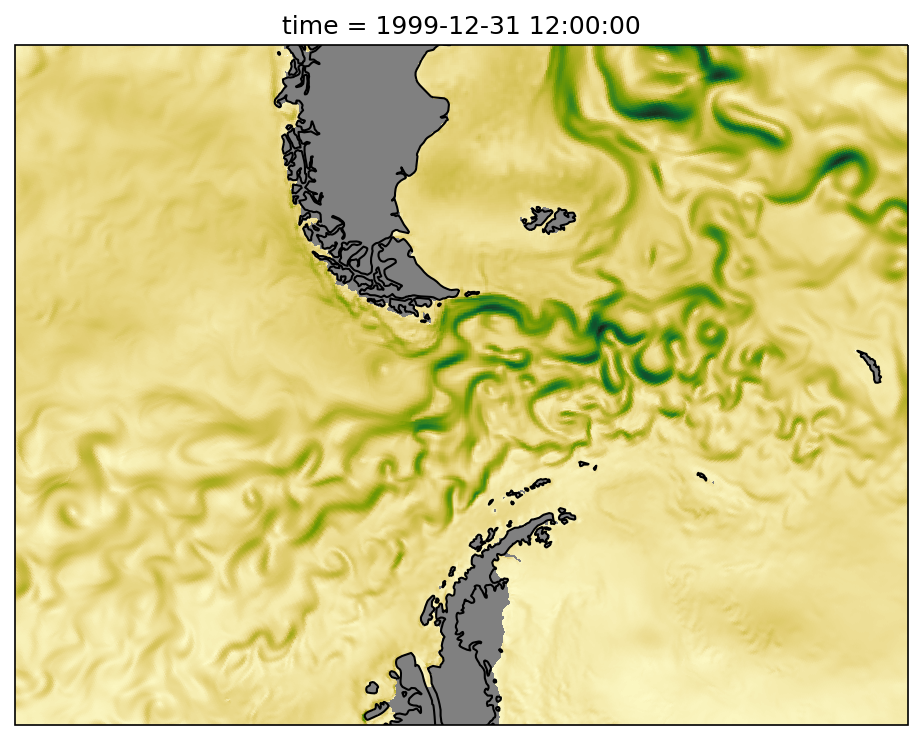

In [8]:
projection=ccrs.Stereographic(central_latitude=-55, central_longitude=-65)

fig = plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(1, 1, 1, projection=projection)
speed.isel(time=-1).plot(ax=ax,add_colorbar=False,vmin=0,vmax=1.2,
                     transform=ccrs.PlateCarree(),cmap=cm.cm.speed)
ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')

ax.coastlines(resolution='50m')
ax.set_extent([-90, -40, -70, -45], crs=ccrs.PlateCarree())
#ax.set_boundary(circle, transform=ax.transAxes)
#plt.savefig('figures/DP.png')


In [ ]:
#Drake Passage
projection=ccrs.Stereographic(central_latitude=-55, central_longitude=-65)

fig = plt.figure(figsize=(8, 6), dpi=150)
for ii in range(speed.time.size):
    
    speed_frame = speed.isel(time=ii)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    speed_frame.plot(add_colorbar=False,vmin=0,vmax=1.2,
                     transform=ccrs.PlateCarree(),cmap=cm.cm.speed)
    ax.contourf(depth.xh,depth.yh,land_mask,transform=ccrs.PlateCarree(),colors='grey')
    ax.coastlines(resolution='50m')
    ax.set_extent([-90, -40, -70, -45], crs=ccrs.PlateCarree())
    
    plt.title('')
    plt.tight_layout()
    
    filestr = '/g/data/x77/amh157/drake-frames/image%04d.png' % ii
    plt.savefig(filestr,dpi=150)
    plt.clf()
    if np.mod(ii,10)==0:
        print(ii)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
